In [14]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os
import xarray as xr
import torch

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

import netCDF4 as nc
import glob

from functions.plot_metrics import plot_metrics
from functions.plot_metrics_one import plot_metrics_one
from functions import calc_metrics

In [46]:
data_water=parse.parse('cloudrm3_water_newsurf.dat')
data_clear=parse.parse('cloudrm3_clear_newsurf.dat')
data_ice=parse.parse('cloudrm3_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm3_mixed_newsurf.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water,data_clear,data_ice,data_mixed,
#                    data_black_water,data_black_clear,data_black_ice,data_black_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])


data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13','Sun_Zenith_Angle']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']
#clear_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
#              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
#              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

#y_labels= ['OCloud_B02','OCloud_B03','OCloud_B04','OCloud_B05','OCloud_B06',
#           'OCloud_B07','OCloud_B08','OCloud_B09','OCloud_B10','OCloud_B11','OCloud_B12','OCloud_B13']

#df[y_labels]=df[X_labels].to_numpy()-df[clear_labels].to_numpy()

In [47]:
X=df[X_labels]
y=df[y_labels]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [48]:
clear_indices=X_train[df.loc[X_train.index]['COT']>0].index
clear_indices_test=X_test[df.loc[X_test.index]['COT']>0].index

In [49]:
X_train.loc[clear_indices] = X_train.loc[clear_indices] + np.random.randn(len(clear_indices),np.shape(X_train)[1]) * np.mean(X_train.to_numpy(),axis=0)*0.03
X_test.loc[clear_indices_test] = X_test.loc[clear_indices_test] + np.random.randn(len(clear_indices_test),np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [50]:
#Normalise
X_mean_xg=np.mean(X_train,axis=0).to_numpy()
X_std_xg=np.std(X_train,axis=0).to_numpy()
X_train=(X_train-X_mean_xg)/X_std_xg

X_test=(X_test-X_mean_xg)/X_std_xg


In [51]:
print(np.mean(X_train,axis=0).to_numpy())
print(np.std(X_train,axis=0).to_numpy())
print(" ")
print(np.mean(X_test,axis=0).to_numpy())
print(np.std(X_test,axis=0).to_numpy())

[ 9.91207116e-17  1.42108547e-17 -5.40012479e-17 -2.24353869e-16
  6.39488462e-18  1.03739239e-15  2.39985809e-16 -1.98951966e-17
  1.67155179e-16 -1.28963507e-16  3.60600438e-17 -2.61124455e-16
  6.11777295e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 
[-0.00070411 -0.00208518 -0.00252571 -0.00260174 -0.00435385 -0.00585845
 -0.00454013 -0.00743992  0.00455784  0.00917262 -0.00580416 -0.00456195
  0.00246665]
[1.00254604 1.00312609 1.00300003 1.00451019 1.00819956 1.01008817
 1.00850863 1.00999318 1.00123792 1.01207564 1.0006082  1.00059224
 0.99658704]


In [52]:
def custom_learning_rate(iterations):
  """
  This function reduces the learning rate by 0.1 every 10 iterations.
  """
  return 0.1 * (1.0 - (iterations / 10))

In [53]:
import cupy as cp
import xgboost as xgb
# Define your training and target data (replace with your actual data)
# Your training features
# Your training target values

# Create the XGBoost regressor model
X_train_gpu = cp.asarray(X_train.to_numpy())
y_train_gpu = cp.asarray(y_train.to_numpy())
models=[]

for i in range(5):

    model = xgb.XGBRegressor(device='cuda',n_estimators=500,
                            max_depth=5,
                            learning_rates=custom_learning_rate,
                            loss='squared_error')

    # Train the model on the training data
    model.fit(X_train_gpu, y_train_gpu)
    models.append(model)

# Make predictions on new data (replace with your new data)
X_new = X_test# Your new features
y_pred = model.predict(X_new)


/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:08:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:08:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:08:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:09:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are not used.

  warnings.warn(smsg, UserWarning)
/home/edgelab/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:09:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "loss" } are n

In [54]:
mean_squared_error(y_test,y_pred)

0.006741241550103871

In [55]:
main_dir='/cloud/skogsstyrelsen_pairs/'
directories=os.listdir(main_dir)
#directories

In [56]:
sun_zenith_np=np.array([48.10258555, 46.62837522, 47.6459767 , 31.83072945,
                        33.69190491, 35.67351442, 46.42774732, 37.15326461, 41.34795651,
                        47.11931233, 47.08281932, 29.37867897, 31.23052966, 26.21048804,
                        26.99746596, 51.1544963 , 50.2538547 , 53.23794325, 52.70034371,
                        44.14381837, 48.3205705 , 50.30765058, 48.71353692, 36.1154744 ,
                        36.98005634, 32.56612326, 33.45330837, 37.14737277, 37.95840042,
                        41.20877219, 41.14310695, 46.16254884, 45.40657544, 37.27761812,
                        42.17245033, 52.12410723, 51.59146449, 43.93344343, 49.41213256])

In [57]:
ims_all=[]
temporals_all=[]
dataset_all=[]
for dir in directories:
    data_clear=xr.load_dataset(main_dir+dir+'/clear_data.nc', engine='netcdf4', decode_times=True)
    data_cloudy=xr.load_dataset(main_dir+dir+'/cloudy_data.nc', engine='netcdf4', decode_times=True)

    variables=data_clear.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    c_mask=variables['cloud_mask'].data

    ## Save image ##
    im_clear=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_clear[:,:,0]=b02
    im_clear[:,:,1]=b03
    im_clear[:,:,2]=b04
    im_clear[:,:,3]=b05
    im_clear[:,:,4]=b06
    im_clear[:,:,5]=b07
    im_clear[:,:,6]=b08
    im_clear[:,:,7]=b8a
    im_clear[:,:,8]=b09
    im_clear[:,:,9]=b10
    im_clear[:,:,10]=b11
    im_clear[:,:,11]=b12
    im_clear[:,:,12]=sun_z
    im_clear[:,:,13]=c_mask

    variables=data_cloudy.variables

    ## Get bands ##
    b02=variables['b02'].data
    b03=variables['b03'].data
    b04=variables['b04'].data
    b05=variables['b05'].data
    b06=variables['b06'].data
    b07=variables['b07'].data
    b08=variables['b08'].data
    b8a=variables['b8a'].data
    b09=variables['b09'].data
    b10=variables['b10'].data
    b11=variables['b11'].data
    b12=variables['b12'].data
    sun_z=variables['sun_zenith_angle'].data
    cot=variables['cloud_mask'].data

    ## Save image ##
    im_cloudy=np.zeros((np.shape(b03)[0],np.shape(b03)[1],14))
    im_cloudy[:,:,0]=b02
    im_cloudy[:,:,1]=b03
    im_cloudy[:,:,2]=b04
    im_cloudy[:,:,3]=b05
    im_cloudy[:,:,4]=b06
    im_cloudy[:,:,5]=b07
    im_cloudy[:,:,6]=b08
    im_cloudy[:,:,7]=b8a
    im_cloudy[:,:,8]=b09
    im_cloudy[:,:,9]=b10
    im_cloudy[:,:,10]=b11
    im_cloudy[:,:,11]=b12
    im_cloudy[:,:,12]=sun_z
    im_cloudy[:,:,13]=cot

    t_is_cloud = 0.025*50 # From Alex
    t_thin_cloud = 0.015*50 # From Alex
    im_shape=np.shape(im_cloudy)
    c_mask=cot
    c_mask=np.reshape(c_mask,im_shape[0]*im_shape[1])
    c_mask[c_mask<t_thin_cloud]=0
    c_mask[(c_mask>t_thin_cloud)&(c_mask<t_is_cloud)]=1
    c_mask[c_mask>t_is_cloud]=2
    c_mask=np.reshape(c_mask,(im_shape[0],im_shape[1]))

    im_cloudy_cmask=np.zeros((im_shape[0],im_shape[1],im_shape[2]+1))
    im_cloudy_cmask[:,:,0:14]=im_cloudy
    im_cloudy_cmask[:,:,-1]=c_mask

    im_pair=[im_clear,im_cloudy_cmask]
    ims_all.append(im_pair)
    temporals_all.append([data_clear.coords['t'].data[0],data_cloudy.coords['t'].data[0]])
    dataset_all.append([data_clear,data_cloudy])

In [58]:
sun_zenith=[[48.1025855529559, 46.628375222253],
 [47.6459766976532, 48.2966614462017],
 [31.8307294519636, 33.6919049126475],
 [37.1532646072091, 41.3479565093359],
 [47.1193123274645, 47.082819317679],
 [29.378678967314002, 31.2305296555376],
 [26.2104880350754, 26.9974659569815],
 [51.1544962980685, 50.2538547015424],
 [53.2379432474838, 52.7003437149599],
 [44.1438183686606, 48.3205704990423],
 [50.3076505787152, 48.7135369190245],
 [36.1154743953194, 36.980056336768],
 [32.5661232557218, 33.4533083718023],
 [37.1473727722291, 37.9584004238096],
 [41.2087721889146, 41.1431069536213],
 [46.1625488358176, 45.4065754394836],
 [37.2776181154956, 42.1724503339503],
 [52.1241072275299, 51.5914644875397],
 [43.9334434282729, 49.4121325584673]]

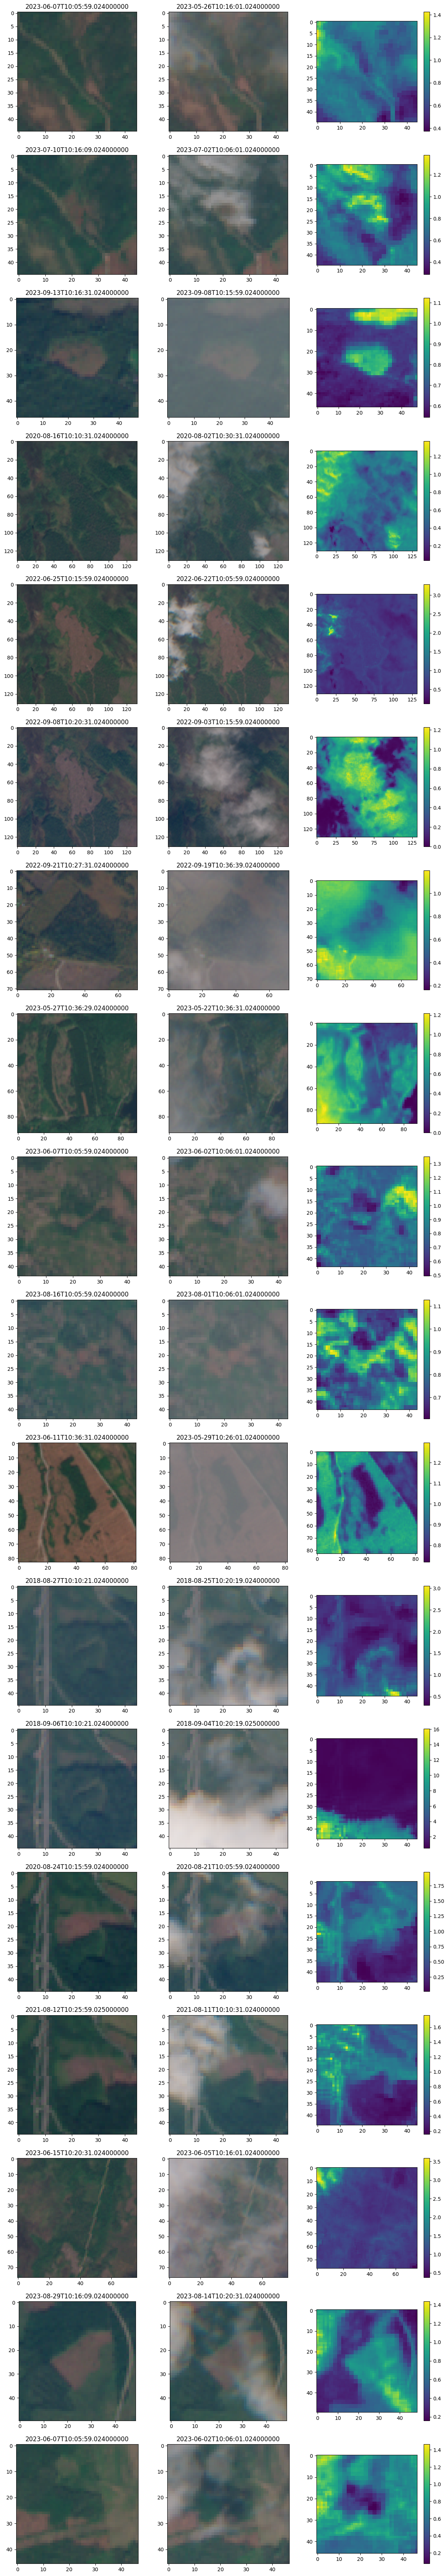

In [59]:
ncols=3
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    s_z=sun_zenith[i]
    ims_all[i][0][:,:,12]=s_z[0] #Update sun zenith angles
    ims_all[i][1][:,:,12]=s_z[1] #Update sun zenith angles
    im_clear=pair[0]
    im_cloud=pair[1]

    im_clear_show=hf.Sentinel2TrueColor(im_clear)
    im_cloud_show=hf.Sentinel2TrueColor(im_cloud)

    axs[pair_c,0].imshow(im_clear_show)
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(im_cloud_show)
    axs[pair_c,1].set_title(temporals_all[i][1])
    im_c=axs[pair_c,2].imshow(im_cloud[:,:,-2])
    fig.colorbar(im_c,ax=axs[pair_c,2])
    pair_c+=1

In [60]:
len(ims_all)

18

In [61]:
np.mean(im_cloud_r_c[:,0:13],axis=0)

array([1.19972109e-01, 1.05393432e-01, 8.71859852e-02, 1.26399352e-01,
       2.33251526e-01, 2.68711471e-01, 2.69373451e-01, 2.97912858e-01,
       1.29768733e-01, 2.78140611e-03, 1.87852174e-01, 1.04285476e-01,
       5.15914645e+01])

In [62]:
preds_all=[]
for i,pair in enumerate(ims_all):
    im_cloud=pair[1]

    ## Reshape cloudy data
    im_shape=np.shape(im_cloud)
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
    for i in range(im_shape[2]):
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_cot_t_r=im_cloud_r[:,-1]
    #One hot encode cot
    cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
    cot_one_hot[im_pred_cot_t_r==0,0]=1
    cot_one_hot[im_pred_cot_t_r==1,1]=1
    cot_one_hot[im_pred_cot_t_r==2,2]=1

    ## append cot estimation to input data ##
    im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+3))
    im_cloud_r_c[:,0:14]=im_cloud_r[:,0:14]
    im_cloud_r_c[:,15:19]=cot_one_hot

    input=im_cloud_r_c[:,0:13]
    input=(input-X_mean_xg)/X_std_xg

    ## Make prediction
    for i,model in enumerate(models):
        if i==0:
            pred=model.predict(input)
        else:   
            pred=pred+model.predict(input)
    pred=pred/len(models)

    ##Reshape back
    im_shape_pred=(im_shape[0],im_shape[1],12)
    im_pred=np.zeros(im_shape_pred)
    im_unc=np.zeros(im_shape_pred)
    for i in range(im_shape_pred[2]):
        im_pred[:,:,i]=np.reshape(pred[:,i],im_shape_pred[0:2])

    preds_all.append(im_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


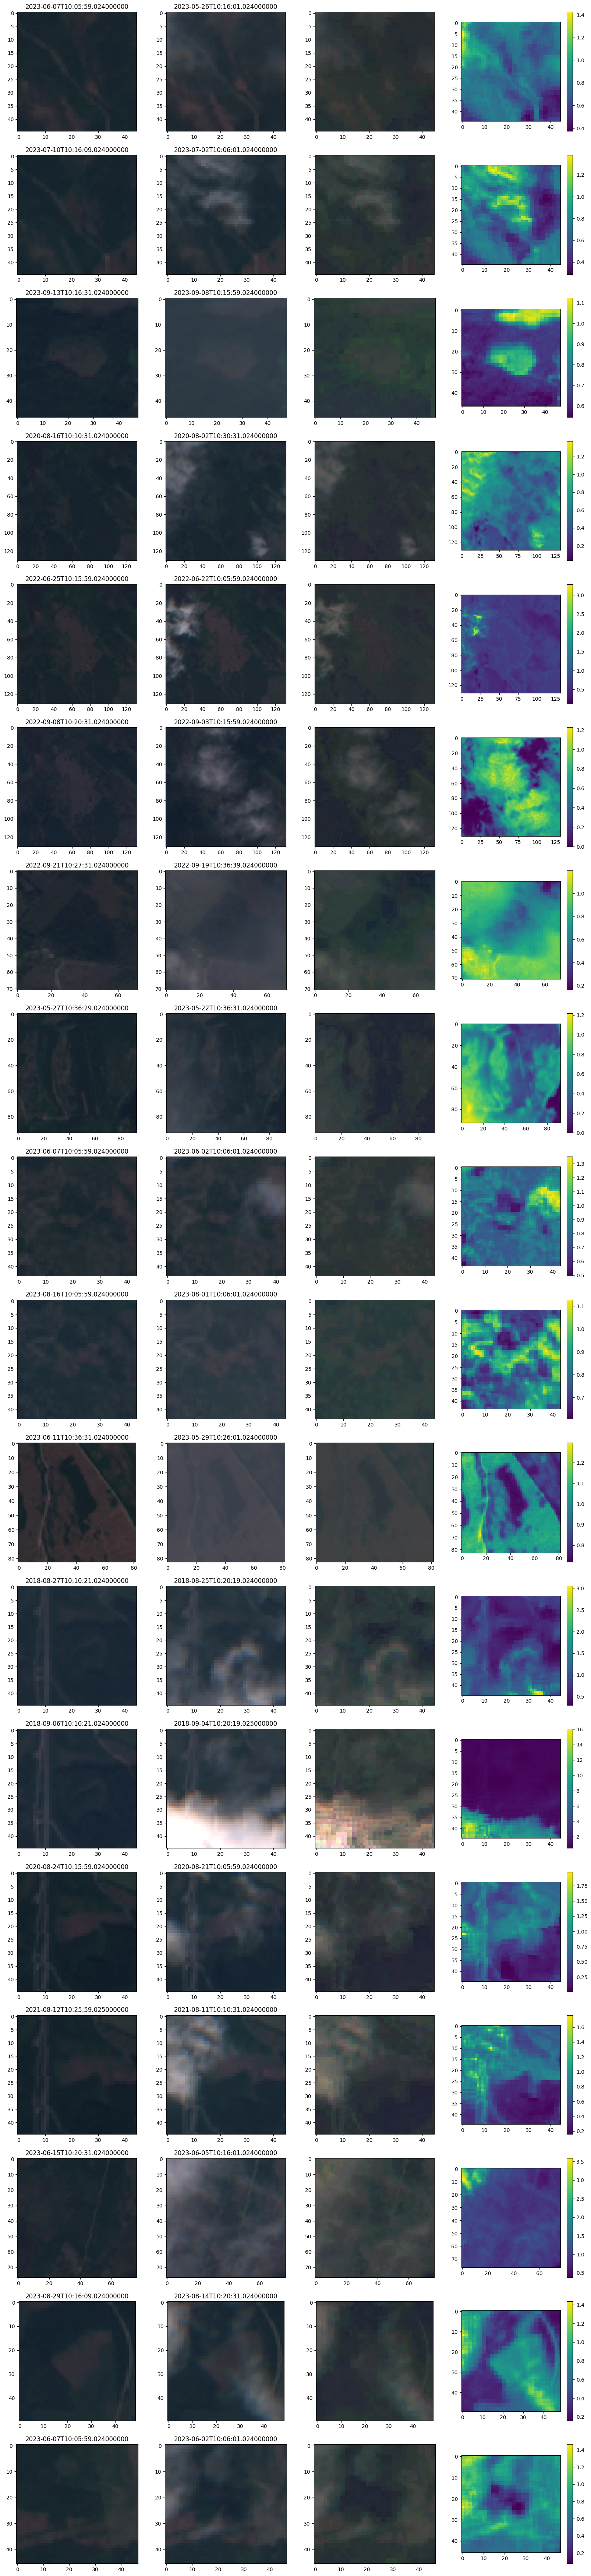

In [63]:
ncols=4
nrows=len(ims_all)

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig,axs=plt.subplots(ncols=ncols,nrows=nrows)

pair_c=0
for i,pair in enumerate(ims_all):

    im_clear=pair[0]
    im_cloud=pair[1]

    axs[pair_c,0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
    axs[pair_c,0].set_title(temporals_all[i][0])
    axs[pair_c,1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
    axs[pair_c,1].set_title(temporals_all[i][1])
    axs[pair_c,2].imshow(np.flip(preds_all[i][:,:,0:3],axis=2)*2)
    im_c=axs[pair_c,3].imshow(im_cloud[:,:,-2])
    fig.colorbar(im_c,ax=axs[pair_c,3])
    pair_c+=1

## Evaluate predictions

In [64]:
n_pairs=len(preds_all)

NMSEs_og=np.zeros((n_pairs,12))
NMSEs_pred=np.zeros((n_pairs,12))

p_c=0
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    #np.linal.norm() -> Frobenius norm i.e root of the sum of squares
    norm_og=np.linalg.norm((im_clear[:,:,0:12])-(im_cloud[:,:,0:12]),axis=(0,1))**2
    norm_pred=np.linalg.norm(im_clear[:,:,0:12]-im_pred[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear[:,:,0:12],axis=(0,1))**2

    NMSE_og=norm_og/norm_gt
    NMSE_pred=norm_pred/norm_gt

    NMSEs_og[p_c,:]=NMSE_og
    NMSEs_pred[p_c,:]=NMSE_pred
    p_c+=1

mean_NMSE_og=np.mean(NMSEs_og,axis=0)
mean_NMSE_pred=np.mean(NMSEs_pred,axis=0)

mean_NMSE_og_wo_10=np.concatenate((mean_NMSE_og[0:9],mean_NMSE_og[10:]),axis=0)
mean_NMSE_pred_wo_10=np.concatenate((mean_NMSE_pred[0:9],mean_NMSE_pred[10:]),axis=0)

In [65]:
mean_NMSE_og_wo_10

array([0.40022543, 0.62128908, 1.51165044, 0.72502117, 0.18495176,
       0.14537586, 0.13273871, 0.12652203, 0.61738734, 0.37774502,
       1.26366801])

In [66]:
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(np.round(mean_NMSE_pred[i],4)))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(np.round(mean_NMSE_pred[i],4)))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(mean_NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(np.round(mean_NMSE_pred[i],4)))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(mean_NMSE_og)))
print('Mean NMSE after correction: '+str(np.round(np.mean(mean_NMSE_pred),4)))    

print(' ')

print('Mean NMSE before correction, without band 10: '+str(np.mean(mean_NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.round(np.mean(mean_NMSE_pred_wo_10),4)))    

NMSE before correction, Band 2: 0.40022542608828293
NMSE after correction, Band 2: 0.1158
 
NMSE before correction, Band 3: 0.6212890787256616
NMSE after correction, Band 3: 0.322
 
NMSE before correction, Band 4: 1.5116504378187048
NMSE after correction, Band 4: 0.8447
 
NMSE before correction, Band 5: 0.7250211653587733
NMSE after correction, Band 5: 0.4462
 
NMSE before correction, Band 6: 0.18495176309883093
NMSE after correction, Band 6: 0.1672
 
NMSE before correction, Band 7: 0.14537585927097002
NMSE after correction, Band 7: 0.1187
 
NMSE before correction, Band 8: 0.1327387139056492
NMSE after correction, Band 8: 0.1184
 
NMSE before correction, Band 8A: 0.12652202716872862
NMSE after correction, Band 8A: 0.1016
 
NMSE before correction, Band 9: 0.6173873387396649
NMSE after correction, Band 9: 0.4067
 
NMSE before correction, Band 10: 1.8206887445567332
NMSE after correction, Band 10: 0.7272
 
NMSE before correction, Band 11: 0.3777450173524498
NMSE after correction, Band 11:

### Percent from ground truth

In [67]:
in_og=np.zeros((n_pairs,12))
in_pred=np.zeros((n_pairs,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]
    for k in range(12):
        im_pred_b=im_pred[:,:,k]
        im_cloud_b=im_cloud[:,:,k]
        im_truth_b=im_clear[:,:,k]


        im_in_percent=np.abs(im_pred_b-im_truth_b) <= percent*im_truth_b
        im_in_percent_c=np.abs(im_cloud_b-im_truth_b) <= percent*im_truth_b

        in_og[p_c,k]=np.sum(im_in_percent_c)/np.size(im_in_percent_c)
        in_pred[p_c,k]=np.sum(im_in_percent)/np.size(im_in_percent)

    p_c+=1

mean_in_og=np.mean(in_og,axis=0)
mean_in_pred=np.mean(in_pred,axis=0)

In [68]:
print('Percent pixels within '+str(percent*100)+' percent from ground truth')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_in_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_in_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_in_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_in_pred[i]))    

    print(' ')

Percent pixels within 20.0 percent from ground truth
 
OG, Band 2: 0.3948328026962439
Pred, Band 2: 0.5381345049829487
 
OG, Band 3: 0.34751064191050157
Pred, Band 3: 0.2116951709454686
 
OG, Band 4: 0.2582806981413096
Pred, Band 4: 0.12905042172009212
 
OG, Band 5: 0.319821434583182
Pred, Band 5: 0.225617088005443
 
OG, Band 6: 0.5344863758485652
Pred, Band 6: 0.34071233422865954
 
OG, Band 7: 0.569078333071929
Pred, Band 7: 0.5375877495256925
 
OG, Band 8: 0.5681935007402474
Pred, Band 8: 0.5344801273302181
 
OG, Band 8A: 0.5951939716420115
Pred, Band 8A: 0.5857966748703681
 
OG, Band 9: 0.3311785496039334
Pred, Band 9: 0.31247968867171994
 
OG, Band 10: 0.24676907556692024
Pred, Band 10: 0.33448787578551165
 
OG, Band 11: 0.4370805998501738
Pred, Band 11: 0.4673935738257771
 
OG, Band 12: 0.33589990232072486
Pred, Band 12: 0.2866540883107459
 


In [69]:
abs_distances_og=np.zeros((n_pairs,12))
abs_distances_pred=np.zeros((n_pairs,12))

p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    for k in range(12):
        im_pred_b=im_pred[:,:,k]
        im_cloud_b=im_cloud[:,:,k]
        im_truth_b=im_clear[:,:,k]

        abs_dist_pred=np.abs(im_pred_b-im_truth_b)
        abs_dist_og=np.abs(im_cloud_b-im_truth_b)

        abs_distances_og[p_c,k]=np.mean(abs_dist_og)
        abs_distances_pred[p_c,k]=np.mean(abs_dist_pred)

    p_c+=1

mean_dist_og=np.mean(abs_distances_og,axis=0)
mean_dist_pred=np.mean(abs_distances_pred,axis=0)

In [70]:
print('Mean Absolute distance to ground truth: ')
print(' ')
for i in range(len(mean_NMSE_og)):
    if i<=6:
        print('OG, Band ' +str(i+2)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+2)+': '+str(mean_dist_pred[i]))
    elif i==7:
        print('OG, Band '+str(i+1)+'A: '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+'A: '+str(mean_dist_pred[i]))
    else:
        print('OG, Band '+str(i+1)+': '+str(mean_dist_og[i]))
        print('Pred, Band '+str(i+1)+': '+str(mean_dist_pred[i]))    

    print(' ')

Mean Absolute distance to ground truth: 
 
OG, Band 2: 0.03877738550571135
Pred, Band 2: 0.02304825907886376
 
OG, Band 3: 0.037662562760724334
Pred, Band 3: 0.03406536149419395
 
OG, Band 4: 0.04172049666397671
Pred, Band 4: 0.0387757168097756
 
OG, Band 5: 0.04379201342897634
Pred, Band 5: 0.04125377497167697
 
OG, Band 6: 0.04838150564914491
Pred, Band 6: 0.05480573513324052
 
OG, Band 7: 0.052065604941502724
Pred, Band 7: 0.05122575071443017
 
OG, Band 8: 0.05029930477455323
Pred, Band 8: 0.05071275142764495
 
OG, Band 8A: 0.0551440260363631
Pred, Band 8A: 0.05253912929312881
 
OG, Band 9: 0.03167748948851906
Pred, Band 9: 0.02898145774101553
 
OG, Band 10: 0.0012322495469932588
Pred, Band 10: 0.0007902856581193472
 
OG, Band 11: 0.0490383153469264
Pred, Band 11: 0.05059151154882446
 
OG, Band 12: 0.04126850724569878
Pred, Band 12: 0.04328398107881638
 


In [72]:
clear_array=np.zeros((1,12))
pred_array=np.zeros((1,12))
cloud_array=np.zeros((1,14))
cloud_mask_array=np.zeros((1))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)
    c_mask=im_cloud[:,:,-1]
    c_mask_r=np.reshape(c_mask,im_shape[0]*im_shape[1])


    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+2)) #+1 for sun zenith angle

    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_clear_r[:,12]=np.reshape(im_clear[:,:,12],im_shape[0]*im_shape[1])
    im_cloud_r[:,12]=np.reshape(im_cloud[:,:,12],im_shape[0]*im_shape[1])
    im_cloud_r[:,13]=np.reshape(im_cloud[:,:,13],im_shape[0]*im_shape[1])

    clear_array=np.concatenate((clear_array,im_clear_r[:,0:12]))
    pred_array=np.concatenate((pred_array,im_pred_r))
    cloud_array=np.concatenate((cloud_array,im_cloud_r))
    cloud_mask_array=np.concatenate((cloud_mask_array,c_mask_r))

    p_c+=1


In [73]:
band=10

Text(0.5, 1.0, 'Ground truth and prediction, B11')

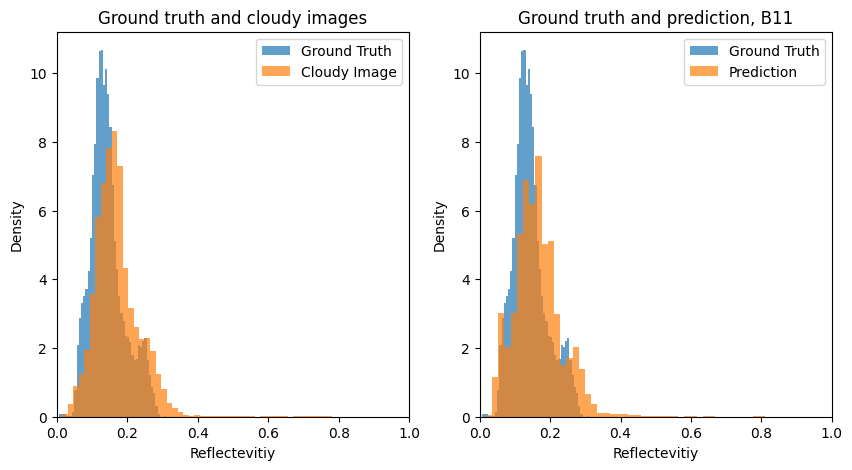

In [74]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]


axs[0].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

#fig.suptitle('Histogram of pixel reflectivity of ground truth, cloudy images and predictions, B11')

In [75]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r>0

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only cloudy pixels, B11')

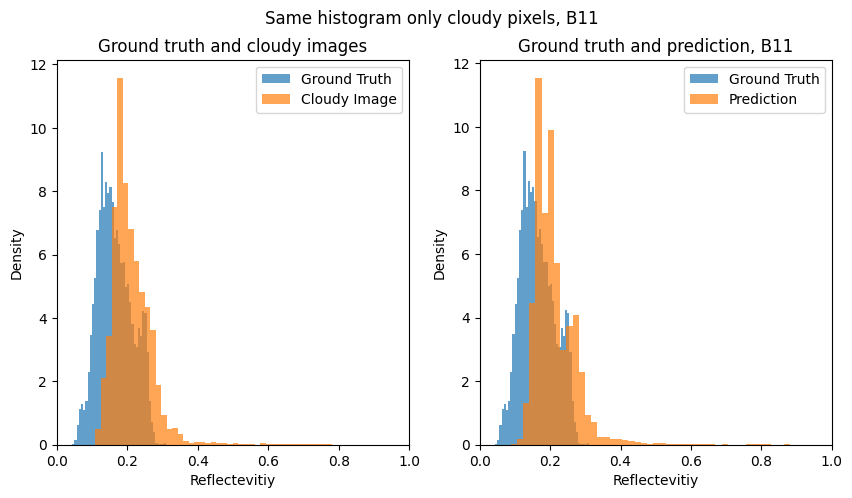

In [76]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only cloudy pixels, B11')

In [77]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==0

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only clear pixels, B11')

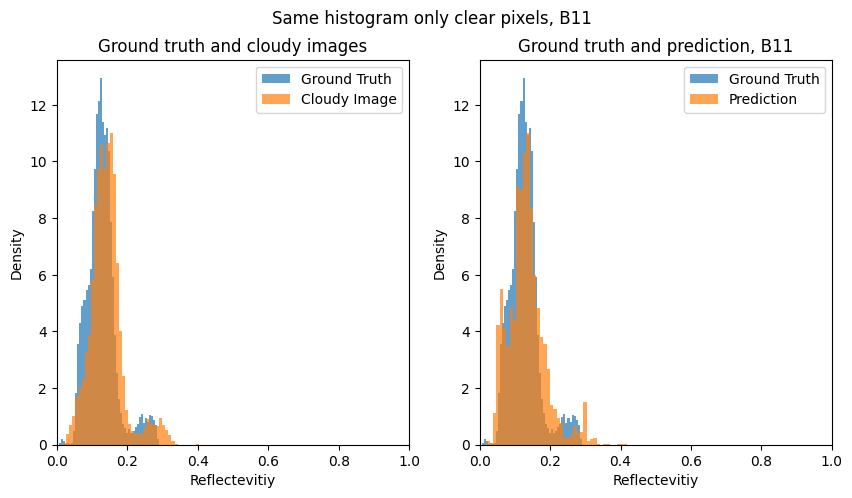

In [78]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only clear pixels, B11')

In [79]:
clear_array_c=np.zeros((1,12))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,12))
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==1

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:12]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))

    p_c+=1

Text(0.5, 0.98, 'Same histogram only thin cloud pixels, B11')

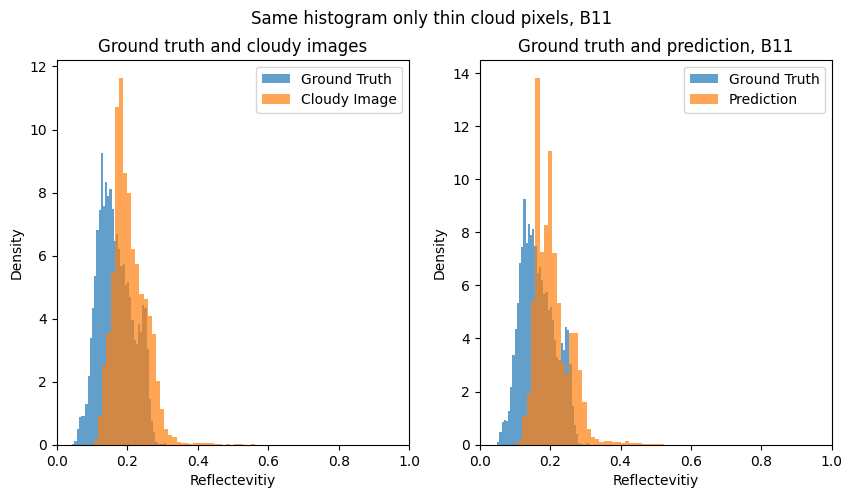

In [80]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thin cloud pixels, B11')

In [81]:
clear_array_c=np.zeros((1,13))
pred_array_c=np.zeros((1,12))
cloud_array_c=np.zeros((1,13))
cots=np.zeros(1)
p_c=0
percent=0.2
for i,pair in enumerate(ims_all):

    im_cloud=pair[1]
    im_clear=pair[0]
    im_pred=preds_all[i]

    im_shape=np.shape(im_pred)

    cloud_mask=im_cloud[:,:,-1]
    cloud_mask_r=np.reshape(cloud_mask,im_shape[0]*im_shape[1])
    cloud_mask_r=cloud_mask_r==2

    im_pred_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
    im_clear_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
    im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
    for i in range(im_shape[2]):
        im_pred_r[:,i]=np.reshape(im_pred[:,:,i],im_shape[0]*im_shape[1])
        im_clear_r[:,i]=np.reshape(im_clear[:,:,i],im_shape[0]*im_shape[1])
        im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

    im_clear_r[:,12]=np.reshape(im_clear[:,:,12],im_shape[0]*im_shape[1])
    im_cloud_r[:,12]=np.reshape(im_cloud[:,:,12],im_shape[0]*im_shape[1])

    im_pred_r=im_pred_r[cloud_mask_r,:]
    im_clear_r=im_clear_r[cloud_mask_r,:]
    im_cloud_r=im_cloud_r[cloud_mask_r,:]


    clear_array_c=np.concatenate((clear_array_c,im_clear_r[:,0:13]))
    pred_array_c=np.concatenate((pred_array_c,im_pred_r))
    cloud_array_c=np.concatenate((cloud_array_c,im_cloud_r))
    cots=np.concatenate((cots,np.reshape(im_cloud[:,:,12],im_shape[0]*im_shape[1])))

    p_c+=1

In [82]:
clear_array_c=clear_array_c[1:,:]
cloud_array_c=cloud_array_c[1:,:]
pred_array_c=pred_array_c[1:,:]


In [83]:
cots

array([ 0.        , 46.62837522, 46.62837522, ..., 51.59146449,
       51.59146449, 51.59146449])

Text(0.5, 0.98, 'Same histogram only thick cloud pixels, B11')

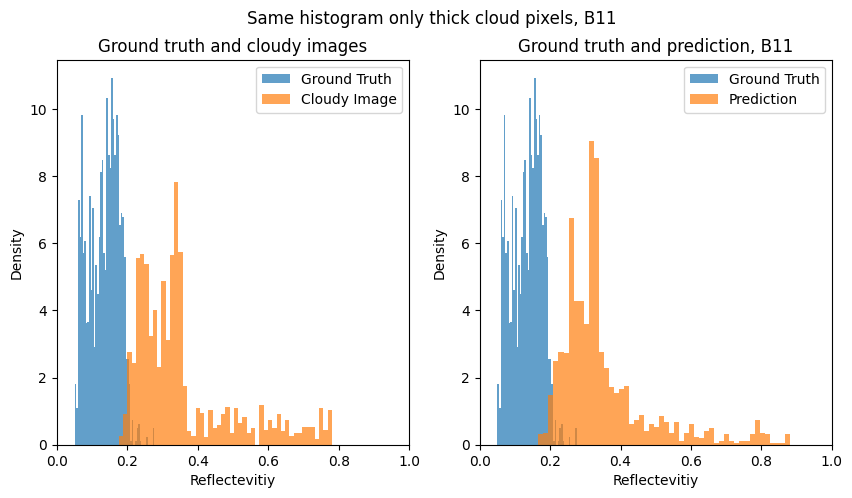

In [84]:
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0]

plt.rcParams['figure.figsize'] = [10, 5]
axs[0].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].hist(cloud_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[0].set_xlim([0,1])
axs[0].legend(['Ground Truth','Cloudy Image'])
axs[0].set_xlabel('Reflectevitiy')
axs[0].set_ylabel('Density')
axs[0].set_title('Ground truth and cloudy images')

axs[1].hist(clear_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].hist(pred_array_c[:,band],alpha=0.7,bins=50,density=True)
axs[1].set_xlim([0,1])
axs[1].legend(['Ground Truth','Prediction'])
axs[1].set_xlabel('Reflectevitiy')
axs[1].set_ylabel('Density')
axs[1].set_title('Ground truth and prediction, B11')

fig.suptitle('Same histogram only thick cloud pixels, B11')

In [85]:
res=clear_array-pred_array

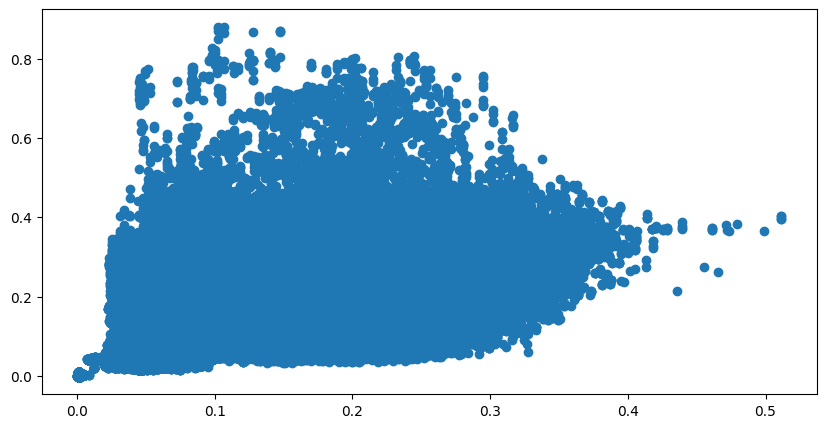

In [86]:
plt.scatter(clear_array,pred_array)

In [87]:
band=10
## Prediction v Ground Truth ##
y_true_11=clear_array[:,band]
pred_y_11=pred_array[:,band]
bins=np.linspace(0,0.6,10)

freq_true=np.zeros(len(bins))
freq_pred=np.zeros(len(bins))

freq_true_zero=np.zeros(len(bins))
freq_pred_zero=np.zeros(len(bins))

freq_true_thin=np.zeros(len(bins))
freq_pred_thin=np.zeros(len(bins))

freq_true_med=np.zeros(len(bins))
freq_pred_med=np.zeros(len(bins))

clear_true=clear_array[cloud_mask_array==0,:]
thin_true=clear_array[cloud_mask_array==1,:]
semi_true=clear_array[cloud_mask_array==2,:]

y_tmp_zero=clear_true[:,band]
y_tmp_thin=thin_true[:,band]
y_tmp_med=semi_true[:,band]

clear_pred=pred_array[cloud_mask_array==0,:]
thin_pred=pred_array[cloud_mask_array==1,:]
semi_pred=pred_array[cloud_mask_array==2,:]

y_tmp_pred_zero=clear_pred[:,band]
y_tmp_pred_thin=thin_pred[:,band]
y_tmp_pred_med=semi_pred[:,band]

for j,edge in enumerate(bins):
    if j!=0:
        indices=(y_true_11>bins[j-1])&(y_true_11<=edge)
        ind_z=(y_tmp_zero>bins[j-1])&(y_tmp_zero<=edge)
        ind_t=(y_tmp_thin>bins[j-1])&(y_tmp_thin<=edge)
        ind_m=(y_tmp_med>bins[j-1])&(y_tmp_med<=edge)

        mean_bin_true=np.mean(y_true_11[indices])
        mean_bin_pred=np.mean(pred_y_11[indices])

        mean_bin_true_zero=np.mean(y_tmp_zero[ind_z])
        mean_bin_pred_zero=np.mean(y_tmp_pred_zero[ind_z])

        mean_bin_true_thin=np.mean(y_tmp_thin[ind_t])
        mean_bin_pred_thin=np.mean(y_tmp_pred_thin[ind_t])

        mean_bin_true_med=np.mean(y_tmp_med[ind_m])
        mean_bin_pred_med=np.mean(y_tmp_pred_med[ind_m])
        
        freq_true[j]=mean_bin_true
        freq_pred[j]=mean_bin_pred


        freq_true_zero[j]=mean_bin_true_zero
        freq_pred_zero[j]=mean_bin_pred_zero


        freq_true_thin[j]=mean_bin_true_thin
        freq_pred_thin[j]=mean_bin_pred_thin


        freq_true_med[j]=mean_bin_true_med
        freq_pred_med[j]=mean_bin_pred_med



/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Ground truth over prediction, Real data')

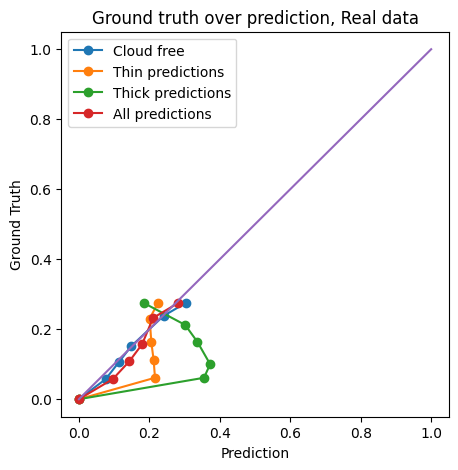

In [88]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.plot(freq_pred_zero,freq_true_zero,'-o')
plt.plot(freq_pred_thin,freq_true_thin,'-o')
plt.plot(freq_pred_med,freq_true_med,'-o')
plt.plot(freq_pred,freq_true,'-o')

#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
plt.plot(line,line)

plt.legend(['Cloud free','Thin predictions','Thick predictions','All predictions'])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Ground truth over prediction, Real data")

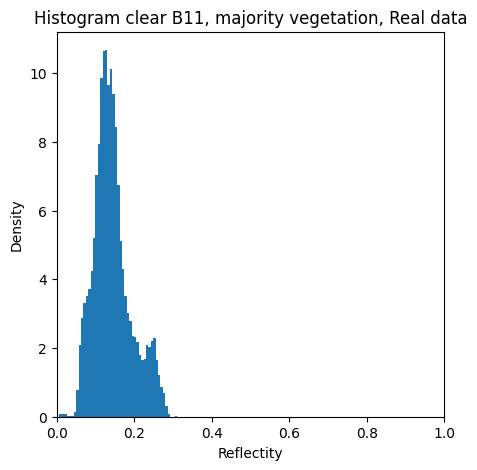

In [89]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.hist(clear_array[:,10],bins=50,density=True)
plt.xlim([0,1])
plt.title('Histogram clear B11, majority vegetation, Real data')
plt.xlabel('Reflectity')
plt.ylabel('Density')
plt.show()

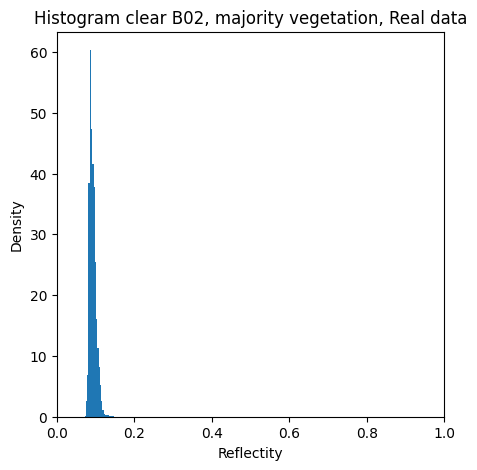

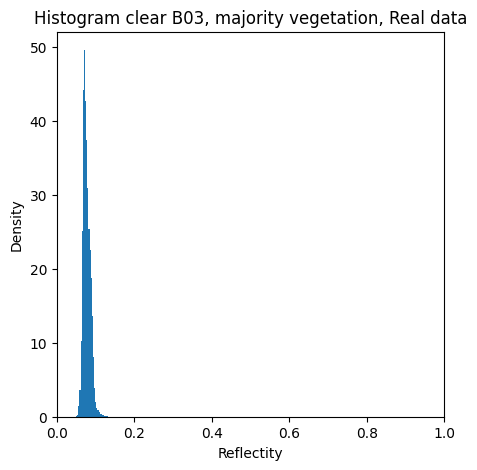

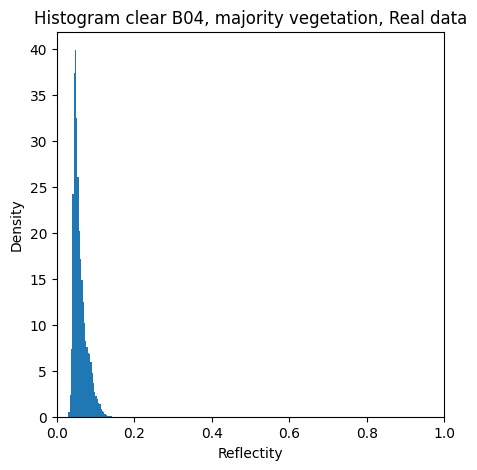

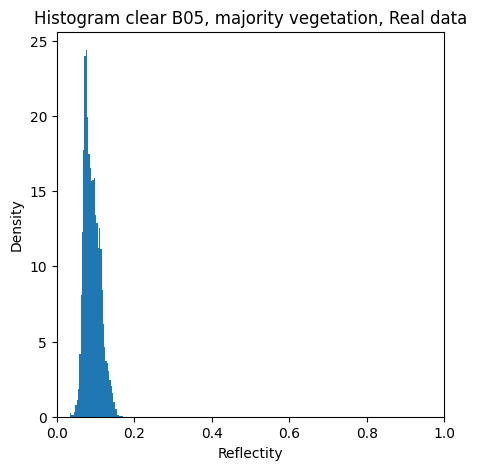

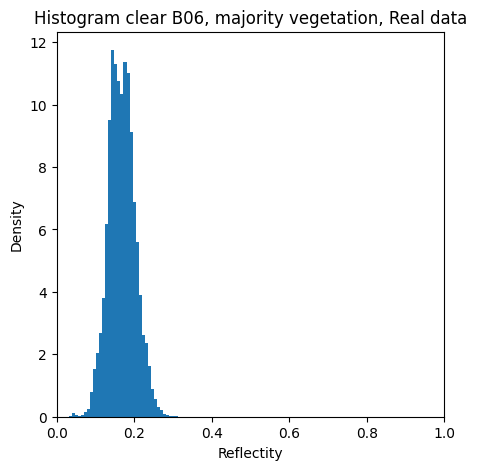

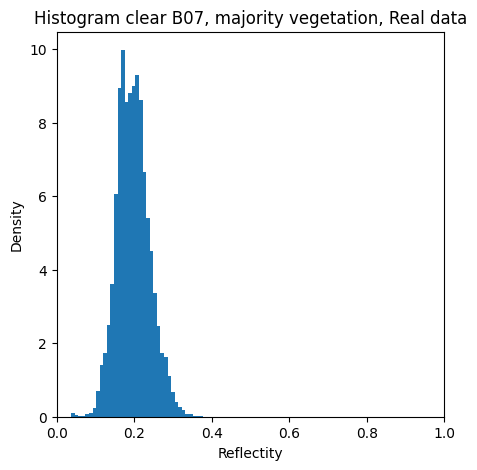

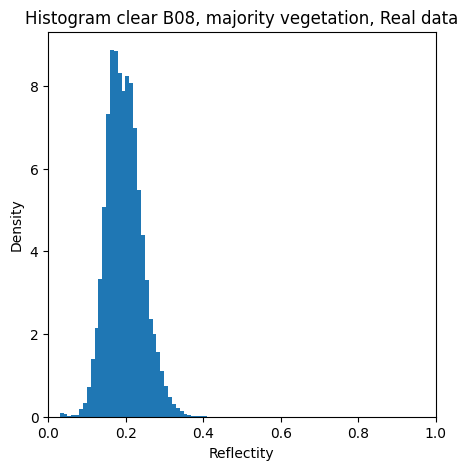

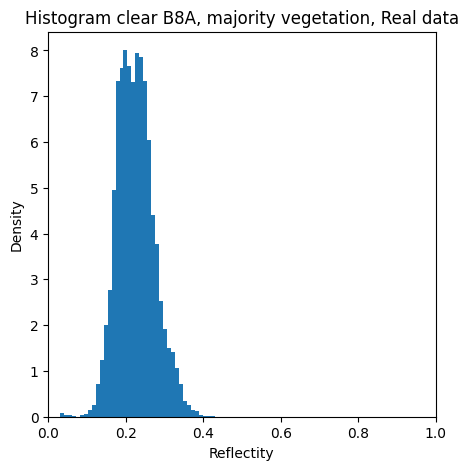

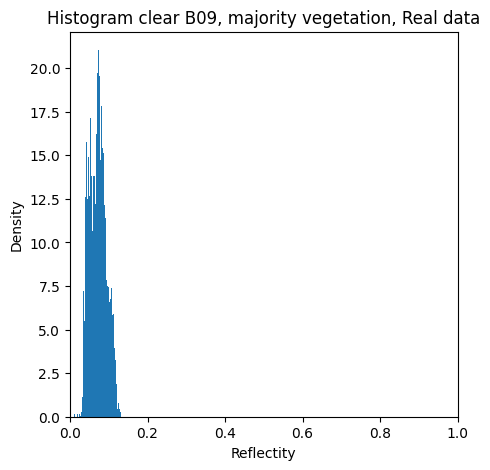

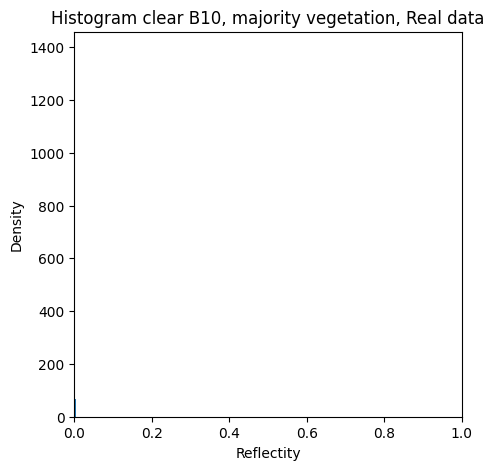

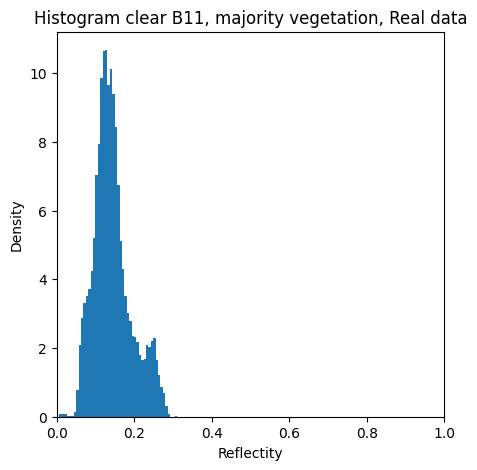

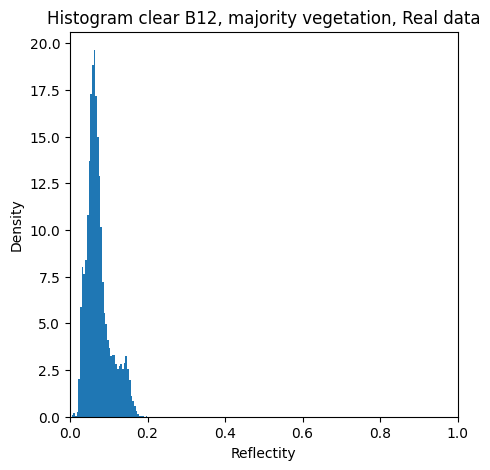

In [90]:
plt.rcParams["figure.figsize"] = [5, 5]
for band in range(0,12):

    plt.hist(clear_array[:,band],bins=50,density=True)
    plt.xlim([0,1])
    if band<7: 
        plt.title('Histogram clear B0'+str(band+2)+', majority vegetation, Real data')
    elif band==7:
        plt.title('Histogram clear B8A, majority vegetation, Real data')
    elif band==8:
        plt.title('Histogram clear B09, majority vegetation, Real data')
    else:
        plt.title('Histogram clear B'+str(band+1)+', majority vegetation, Real data')
    plt.xlabel('Reflectity')
    plt.ylabel('Density')
    plt.show()

## Specific image

In [91]:
which_pair=0 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [92]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

In [93]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

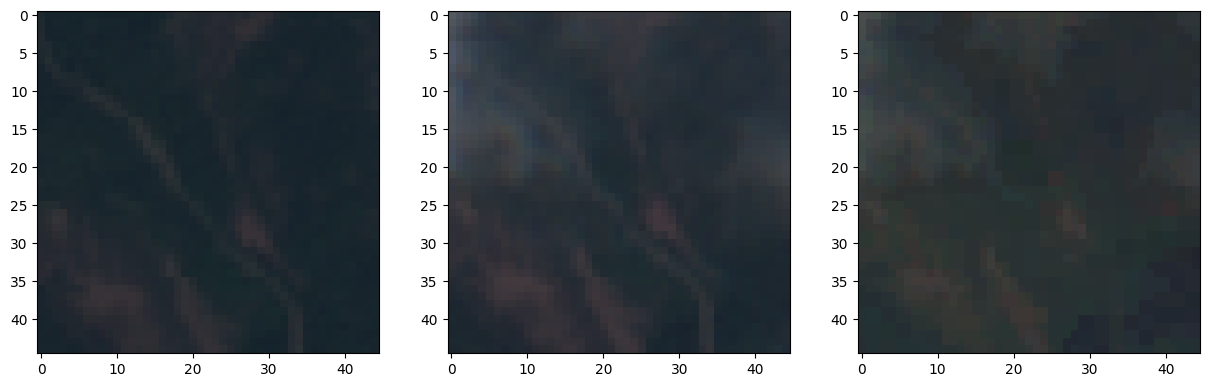

In [94]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(np.flip(im_clear[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_cloud[:,:,0:3],axis=2)*2)
axs[2].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)

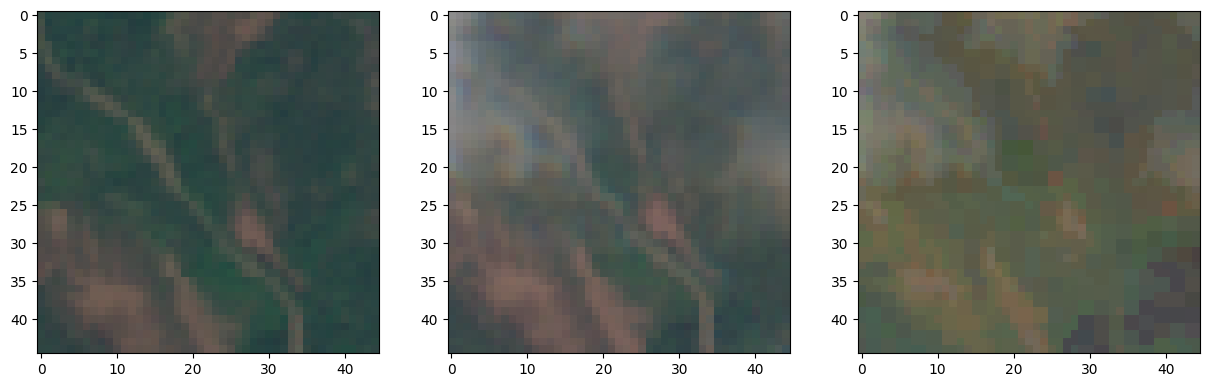

In [95]:
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])

## Test feeding the algorithm a clear image

In [96]:
which_pair=0 #5, 12

im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]


In [97]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

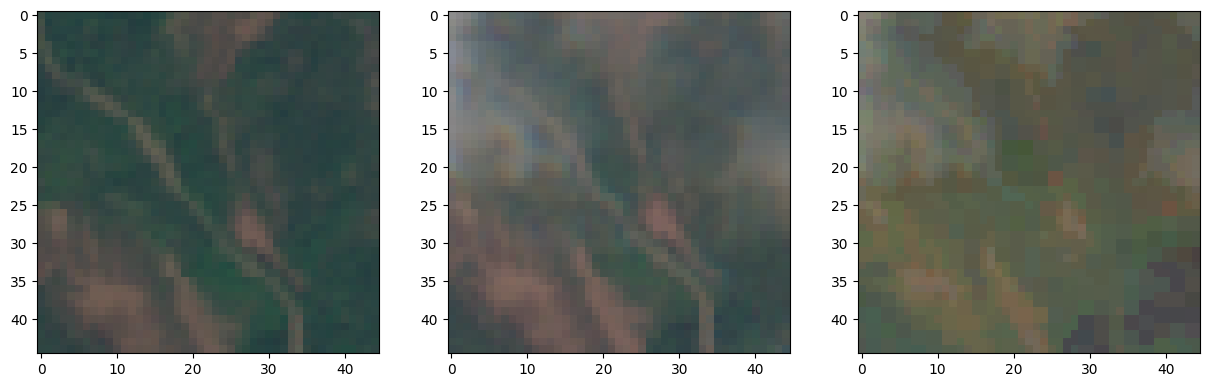

In [98]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])

In [103]:
## Reshape cloudy data
im=im_clear
im_shape=np.shape(im)
im_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]))
for i in range(im_shape[2]):
    im_r[:,i]=np.reshape(im[:,:,i],im_shape[0]*im_shape[1])

input=im_r[:,:13]
input=(input-X_mean_xg)/X_std_xg
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(input)
    else:   
        pred=pred+model.predict(input)
pred=pred/len(models)
##Reshape back
im_shape_pred=(im_shape[0],im_shape[1],12)
im_pred=np.zeros(im_shape_pred)
for i in range(im_shape_pred[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i],im_shape_pred[0:2])

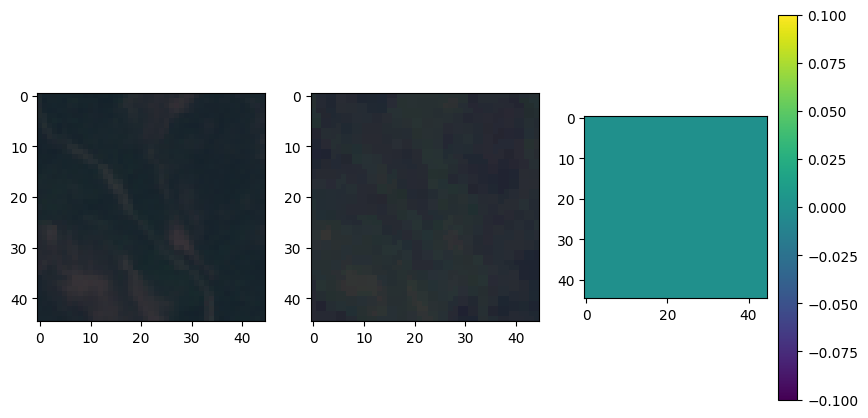

In [104]:
plt.rcParams["figure.figsize"] = [10, 5]
fig,axs=plt.subplots(nrows=1,ncols=3)
axs[0].imshow(np.flip(im[:,:,0:3],axis=2)*2)
axs[1].imshow(np.flip(im_pred[:,:,0:3],axis=2)*2)
i=axs[2].imshow(im[:,:,-1])
fig.colorbar(i,ax=axs[2])

In [105]:

#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm((im[:,:,0:12])-(im[:,:,0:12]),axis=(0,1))**2
norm_pred=np.linalg.norm((im[:,:,0:12])-im_pred[:,:,0:12],axis=(0,1))**2
norm_gt=np.linalg.norm(im[:,:,0:12],axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

NMSE_og_wo_10=np.concatenate((NMSE_og[0:9],NMSE_og[10:]),axis=0)
NMSE_pred_wo_10=np.concatenate((NMSE_pred[0:9],NMSE_pred[10:]),axis=0)

In [106]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(np.round(NMSE_pred[i],4)))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(np.round(NMSE_pred[i],4)))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(np.round(NMSE_pred[i],4)))    

    print(' ')
print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.round(np.mean(NMSE_pred),4))) 

print(' ')
print('Mean NMSE before correction, without band 10: '+str(np.mean(NMSE_og_wo_10)))
print('Mean NMSE after correction, without band 10: '+str(np.round(np.mean(NMSE_pred_wo_10),4)))   

NMSE before correction, Band 2: 0.0
NMSE after correction, Band 2: 0.0141
 
NMSE before correction, Band 3: 0.0
NMSE after correction, Band 3: 0.0258
 
NMSE before correction, Band 4: 0.0
NMSE after correction, Band 4: 0.1347
 
NMSE before correction, Band 5: 0.0
NMSE after correction, Band 5: 0.0245
 
NMSE before correction, Band 6: 0.0
NMSE after correction, Band 6: 0.0207
 
NMSE before correction, Band 7: 0.0
NMSE after correction, Band 7: 0.027
 
NMSE before correction, Band 8: 0.0
NMSE after correction, Band 8: 0.0535
 
NMSE before correction, Band 8A: 0.0
NMSE after correction, Band 8A: 0.0534
 
NMSE before correction, Band 9: 0.0
NMSE after correction, Band 9: 0.0036
 
NMSE before correction, Band 10: 0.0
NMSE after correction, Band 10: 0.0904
 
NMSE before correction, Band 11: 0.0
NMSE after correction, Band 11: 0.0124
 
NMSE before correction, Band 12: 0.0
NMSE after correction, Band 12: 0.0361
 
Mean NMSE before correction: 0.0
Mean NMSE after correction: 0.0413
 
Mean NMSE b

## Spectrum plots

In [107]:
which_pair=16 #5, 12

im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [108]:
## Get "True" RGB Clear##
b04Tp=sAdj(im_clear[:,:,2]-ray['r'])
b03Tp=sAdj(im_clear[:,:,1]-ray['g'])
b02Tp=sAdj(im_clear[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_clear_show=np.zeros(np.shape(im_clear[:,:,0:3]))
im_clear_show[:,:,0]=rgbLin[0]
im_clear_show[:,:,1]=rgbLin[1]
im_clear_show[:,:,2]=rgbLin[2]

## Get "True" RGB Cloudy##
b04Tp=sAdj(im_cloud[:,:,2]-ray['r'])
b03Tp=sAdj(im_cloud[:,:,1]-ray['g'])
b02Tp=sAdj(im_cloud[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_cloud_show=np.zeros(np.shape(im_cloud[:,:,0:3]))
im_cloud_show[:,:,0]=rgbLin[0]
im_cloud_show[:,:,1]=rgbLin[1]
im_cloud_show[:,:,2]=rgbLin[2]


## Get "True" RGB prediction##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros(np.shape(im_pred[:,:,0:3]))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

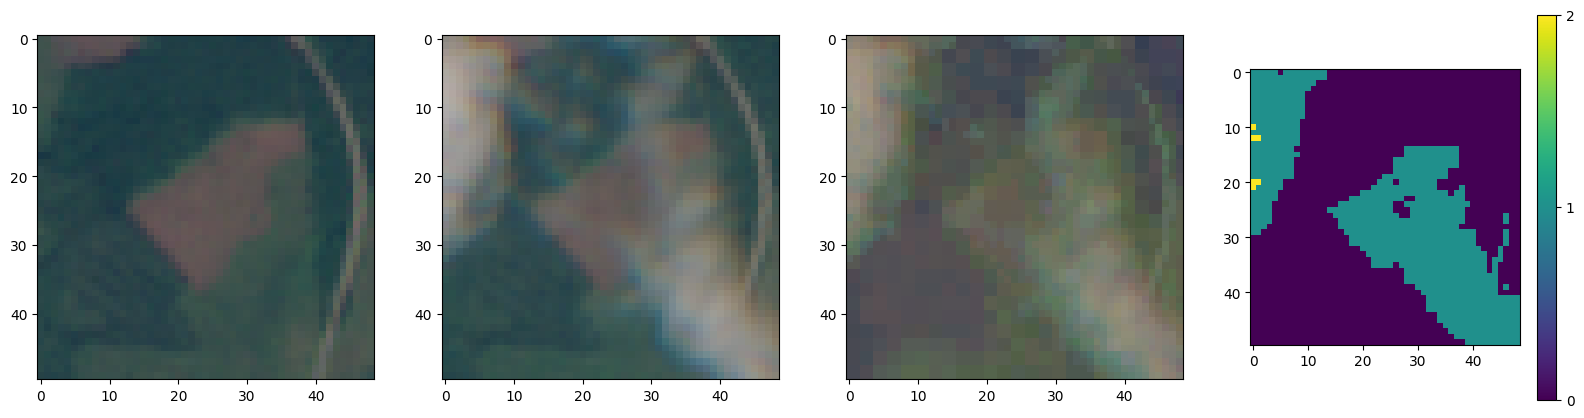

In [109]:
plt.rcParams["figure.figsize"] = [20, 5]
fig,axs=plt.subplots(ncols=4,nrows=1)
axs[0].imshow(im_clear_show[:,:,0:3])
axs[1].imshow(im_cloud_show[:,:,0:3])
axs[2].imshow(im_pred_show[:,:,0:3])
i=axs[3].imshow(im_cloud[:,:,-1])
fig.colorbar(i,ax=axs[3],ticks=[0,1,2])

In [110]:
pixel=(40,35)
pixel_clear=im_clear[pixel[0],pixel[1],:]
pixel_cloud=im_cloud[pixel[0],pixel[1],:]
pixel_pred=im_pred[pixel[0],pixel[1],:]

In [111]:
channels=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B10','B11','B12']

In [112]:
print("COT classification: "+str(pixel_cloud[-1]))

COT classification: 1.0


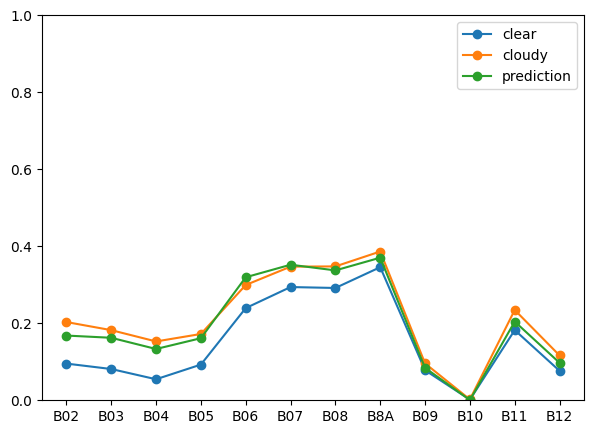

In [113]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(channels,pixel_clear[0:12],'-o')
plt.plot(channels,pixel_cloud[0:12],'-o')
plt.plot(channels,pixel_pred,'-o')
plt.ylim([0,1])
plt.legend(['clear','cloudy','prediction'])
plt.show()

In [114]:
NMSE_pred_synt=np.array([0.00338911, 0.00242884, 0.0027354 , 0.00244613, 0.00229138,
                        0.00212222, 0.00200428, 0.00234764, 0.00266264, 0.00294296,
                        0.00624953, 0.00750336])
NMSE_pred_synt_wo_10=np.array([0.00338911, 0.00242884, 0.0027354 , 0.00244613, 0.00229138,
                                0.00212222, 0.00200428, 0.00234764, 0.00266264, 0.00624953,
                                0.00750336])

In [115]:
channels_wo_10=['B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']

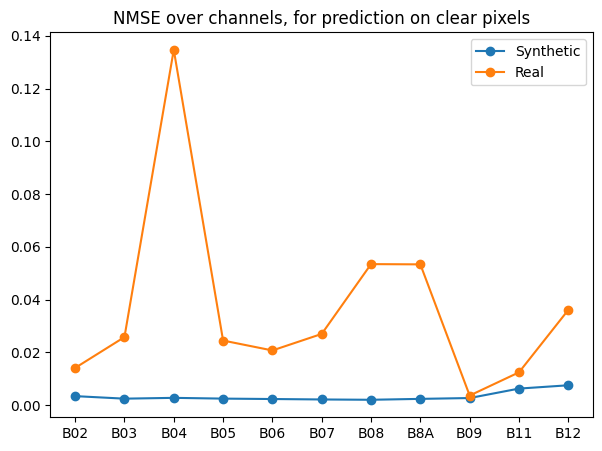

In [116]:
plt.plot(channels_wo_10,NMSE_pred_synt_wo_10,'o-')
plt.plot(channels_wo_10,NMSE_pred_wo_10,'o-')
plt.title('NMSE over channels, for prediction on clear pixels')
plt.legend(['Synthetic','Real'])

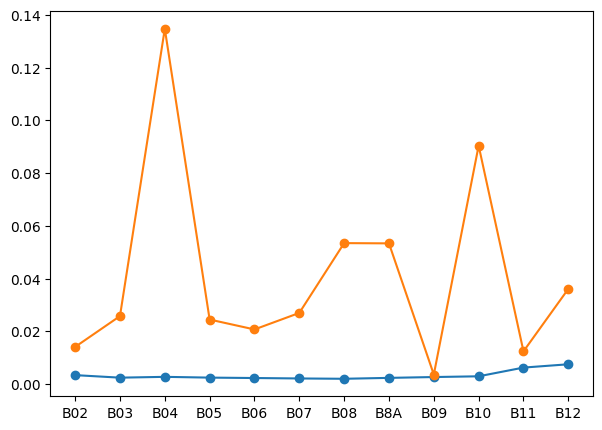

In [117]:
plt.plot(channels,NMSE_pred_synt,'o-')
plt.plot(channels,NMSE_pred,'o-')

In [118]:
np.mean((clear_array_c[:,7]-clear_array_c[:,10])/(clear_array_c[:,7]+clear_array_c[:,10]))

0.24467366815839023

## Polygon analysis

In [119]:
data_water=parse.parse('cloudrm2_water_newsurf.dat')
data_clear=parse.parse('cloudrm2_clear_newsurf.dat')
data_ice=parse.parse('cloudrm2_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm2_mixed_newsurf.dat')

#Concatinate all datasets
df=pd.concat([data_water,data_clear,data_ice,data_mixed])

In [120]:
which_pair=4 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [121]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 1.0, '2022-06-22T10:05:59.024000000')

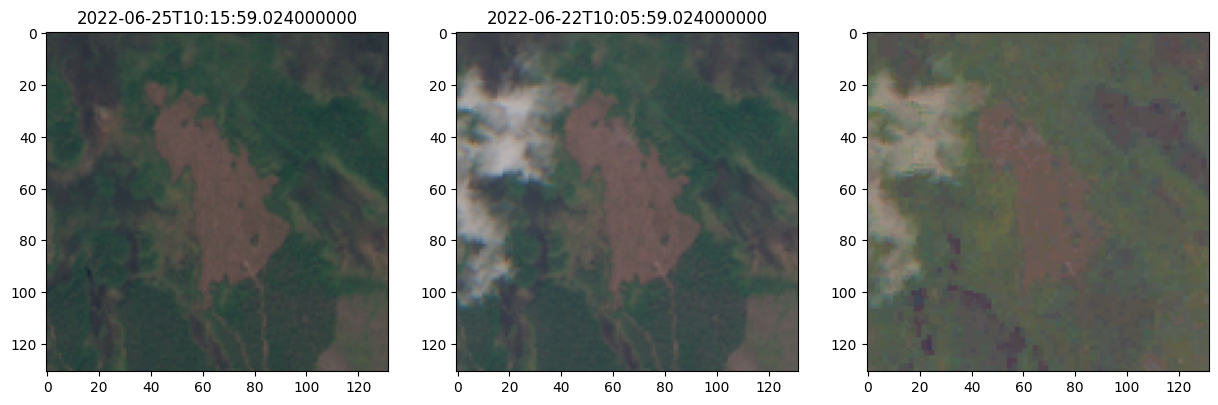

In [122]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show)
axs[1].imshow(im_cloud_show)
axs[2].imshow(im_pred_show)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])

In [123]:
boundbox_x=np.array([65,90])
boundbox_y=np.array([70,90])

im_clear_box=im_clear[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]
im_cloud_box=im_cloud[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]
im_pred_box=im_pred[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]

#Shows
im_clear_box_show=im_clear_show[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]
im_cloud_box_show=im_cloud_show[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]
im_pred_box_show=im_pred_show[boundbox_y[0]:boundbox_y[1],
                      boundbox_x[0]:boundbox_x[1],:]

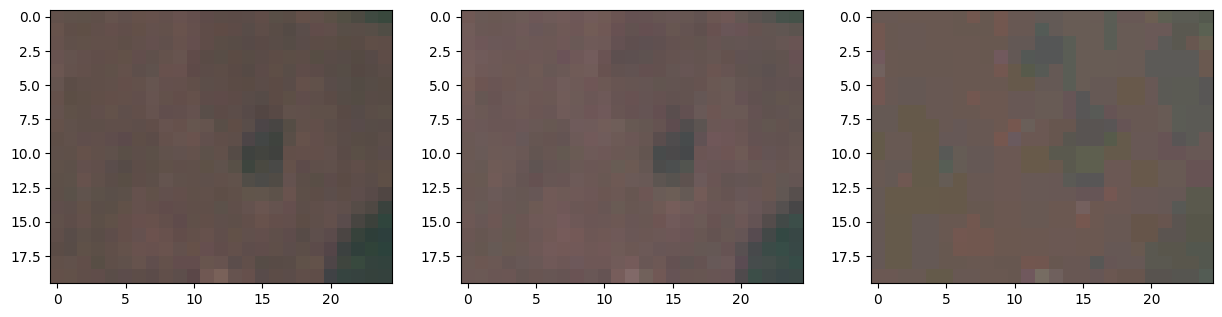

In [124]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_box_show)
axs[1].imshow(im_cloud_box_show)
axs[2].imshow(im_pred_box_show)

In [125]:
mean_spec_clear=np.mean(im_clear_box,axis=(0,1))
mean_spec_cloud=np.mean(im_cloud_box,axis=(0,1))

std_spec_clear=np.std(im_clear_box,axis=(0,1))
std_spec_cloud=np.std(im_cloud_box,axis=(0,1))

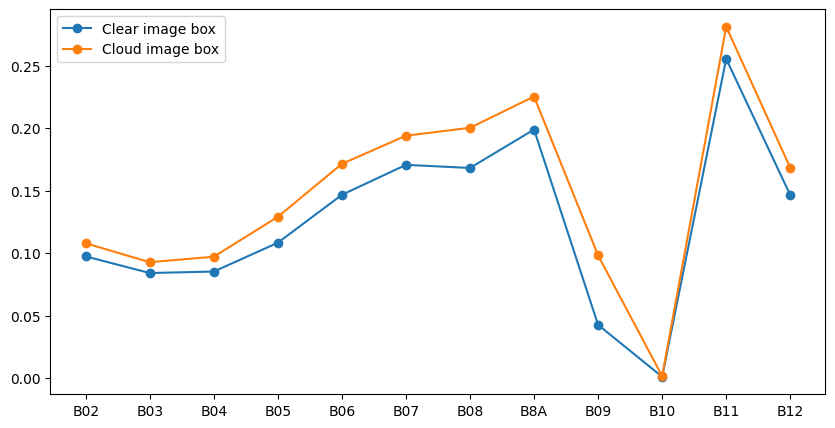

In [126]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.plot(channels,mean_spec_clear[:12],'-o')
plt.plot(channels,mean_spec_cloud[:12],'-o')
plt.legend(['Clear image box','Cloud image box'])

In [127]:
wet_ind_clear_box=(im_clear_box[:,:,7]-im_clear_box[:,:,10])/(im_clear_box[:,:,7]+im_clear_box[:,:,10])
wet_ind_cloud_box=(im_cloud_box[:,:,7]-im_cloud_box[:,:,10])/(im_cloud_box[:,:,7]+im_cloud_box[:,:,10])

In [128]:
print('Moisture index clear image box: '+str(np.mean(wet_ind_clear_box)))
print('Moisture index cloud (clear) image box: '+str(np.mean(wet_ind_cloud_box)))

Moisture index clear image box: -0.12139714953106917
Moisture index cloud (clear) image box: -0.10706718909736863


In [129]:
moist_index_synt=(df['Clear_B09']-df['Clear_B12'])/(df['Clear_B09']+df['Clear_B12'])
mois_index_full_real=(clear_array_c[:,7]-clear_array_c[:,10])/(clear_array_c[:,7]+clear_array_c[:,10])

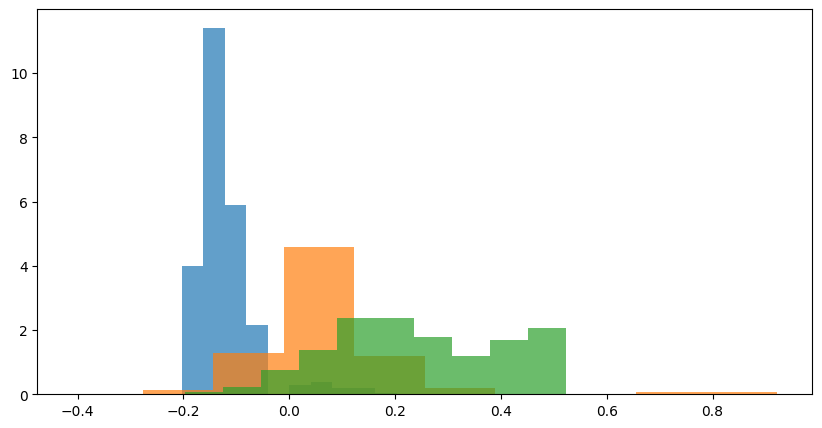

In [130]:
plt.hist(np.reshape(wet_ind_clear_box,np.shape(wet_ind_clear_box)[0]*np.shape(wet_ind_clear_box)[1]),
         bins=10,density=True,alpha=0.7)
plt.hist(moist_index_synt,bins=10,density=True,alpha=0.7)
plt.hist(mois_index_full_real,bins=10,density=True,alpha=0.7)
plt.legend
plt.show()

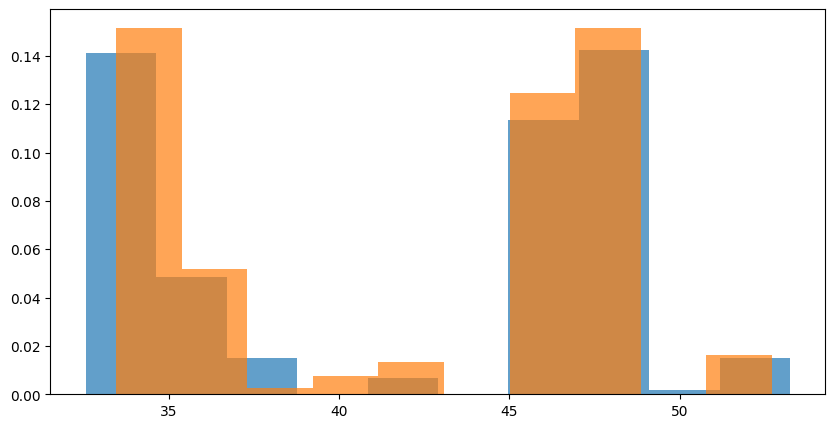

In [131]:
plt.hist(clear_array_c[:,12],bins=10,density=True,alpha=0.7)
plt.hist(cloud_array_c[:,12],bins=10,density=True,alpha=0.7)
plt.show()

## Multi polygon analysis

In [132]:
data_water=parse.parse('cloudrm2_water_newsurf.dat')
data_clear=parse.parse('cloudrm2_clear_newsurf.dat')
data_ice=parse.parse('cloudrm2_ice_newsurf.dat')
data_mixed=parse.parse('cloudrm2_mixed_newsurf.dat')

#Concatinate all datasets
df=pd.concat([data_water,data_clear,data_ice,data_mixed])

In [133]:
which_pair=5 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [134]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 1.0, '2022-09-03T10:15:59.024000000')

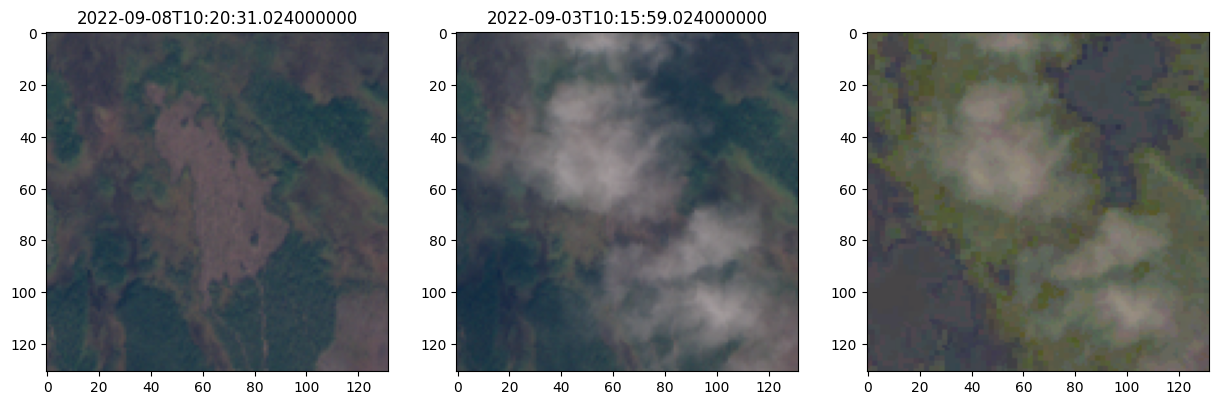

In [135]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show)
axs[1].imshow(im_cloud_show)
axs[2].imshow(im_pred_show)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])

In [136]:
np.shape(im_clear_box)

(20, 25, 14)

In [137]:
bound_box_forest=np.array([[2,30,45,5,20],
                    [3,70,90,65,90],
                    [6,30,40,25,40],
                    [11,30,40,25,40],
                    [12,30,40,25,40],
                    [13,30,40,25,40],
                    [14,35,40,25,40],
                    [16,5,15,5,20],
                    [17,0,20,0,10],
                    [10,60,75,62,78]])#image index, y1,y2,x1,x2

bound_box_cutdown=np.array([[0,35,40,5,12],
                            [2,20,25,23,30],
                            [4,60,80,60,80],
                            [5,60,80,60,80],
                            [6,60,70,30,50],
                            [16,20,30,20,25]])#image index, y1,y2,x1,x2

for i,box in enumerate(bound_box_forest):
    pair=ims_all[box[0]]
    im_clear=pair[0]

    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_clear_box_r=np.reshape(im_clear_box,(np.shape(im_clear_box)[0]*np.shape(im_clear_box)[1],14))
    if i==0:
        im_clear_box_array_forest=im_clear_box_r.copy()
    else:
        im_clear_box_array_forest=np.concatenate((im_clear_box_array_forest,im_clear_box_r))

for i,box in enumerate(bound_box_cutdown):
    pair=ims_all[box[0]]
    im_clear=pair[0]

    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_clear_box_r=np.reshape(im_clear_box,(np.shape(im_clear_box)[0]*np.shape(im_clear_box)[1],14))
    if i==0:
        im_clear_box_array_cutdown=im_clear_box_r.copy()
    else:
        im_clear_box_array_cutdown=np.concatenate((im_clear_box_array_cutdown,im_clear_box_r))



In [138]:
moist_index_forest=(im_clear_box_array_forest[:,7]-im_clear_box_array_forest[:,10])/(im_clear_box_array_forest[:,7]+im_clear_box_array_forest[:,10])
moist_index_cutdown=(im_clear_box_array_cutdown[:,7]-im_clear_box_array_cutdown[:,10])/(im_clear_box_array_cutdown[:,7]+im_clear_box_array_cutdown[:,10])
moist_index_full_real=(clear_array_c[:,7]-clear_array_c[:,10])/(clear_array_c[:,7]+clear_array_c[:,10])
moist_index_synt=(df['Clear_B09']-df['Clear_B12'])/(df['Clear_B09']+df['Clear_B12'])

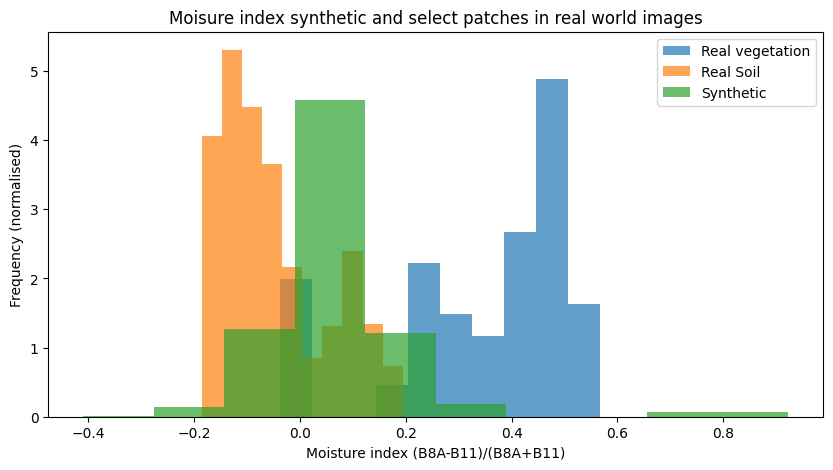

In [139]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(moist_index_forest,bins=10,density=True,alpha=0.7)
plt.hist(moist_index_cutdown,bins=10,density=True,alpha=0.7)
plt.hist(moist_index_synt,bins=10,density=True,alpha=0.7)
#plt.hist(moist_index_full_real,bins=10,density=True,alpha=0.7)
plt.legend(['Real vegetation','Real Soil','Synthetic'])
plt.xlabel('Moisture index (B8A-B11)/(B8A+B11)')
plt.ylabel('Frequency (normalised)')
plt.title("Moisure index synthetic and select patches in real world images")
plt.show()

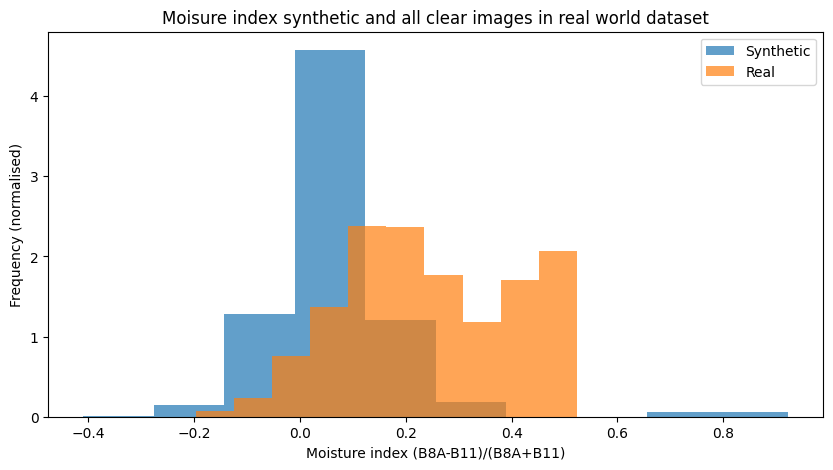

In [140]:
plt.rcParams["figure.figsize"] = [10, 5]
#plt.hist(moist_index_forest,bins=10,density=True,alpha=0.7)
#plt.hist(moist_index_cutdown,bins=10,density=True,alpha=0.7)
plt.hist(moist_index_synt,bins=10,density=True,alpha=0.7)
plt.hist(moist_index_full_real,bins=10,density=True,alpha=0.7)
plt.legend(['Synthetic','Real'])
plt.xlabel('Moisture index (B8A-B11)/(B8A+B11)')
plt.ylabel('Frequency (normalised)')
plt.title("Moisure index synthetic and all clear images in real world dataset")
plt.show()

In [141]:
sattelite_zenith=[[8.39615982624992, 2.7453975585919177],[2.7438290510628445, 8.406385256505317],[7.08162676327482, 7.082989657624074],
                  [7.167164800952244, 8.579385181145392],[2.91761689687252, 7.148978615547262],
                  [2.9242097069456023, 2.914324727656833],[3.430856153699765, 9.447232506786442],[4.505817862554615, 4.49041448331138],
                  [3.7319690116818456, 3.7227992895583144],[3.71957642918129, 3.742850528390725],[3.4038835019566323, 7.252283592172143],
                  [10.5169880082959, 4.650517097229822],[10.517312141672186, 4.636062781023739],[4.672143916002719, 10.546210003509385],
                  [5.40382818657157, 10.547489977954015],[3.0855105252896062, 3.0840209784031294],[7.104267217706174, 7.114932568429697],
                  [10.155987271538024, 10.158299780037224]]

In [142]:
sattelite_zenith_np=np.array([ 8.39615983,  2.74539756,  2.74382905,   7.08162676,
                                7.08298966,  4.59108673,  5.41898977,  7.1671648 ,  8.57938518,
                                2.9176169 ,  7.14897862,  2.92420971,  2.91432473,  3.43085615,
                                9.44723251,  4.50581786,  4.49041448,  3.73196901,  3.72279929,
                                3.71957643,  3.74285053,  3.4038835 ,  7.25228359, 10.51698801,
                                4.6505171 , 10.51731214,  4.63606278,  4.67214392, 10.54621   ,
                                5.40382819, 10.54748998,  3.08551053,  3.08402098,  7.10426722,
                                7.11493257, 10.15598727, 10.15829978])

In [143]:
sun_zenith_np=np.array([48.10258555, 46.62837522, 47.6459767 , 31.83072945,
                        33.69190491, 35.67351442, 46.42774732, 37.15326461, 41.34795651,
                        47.11931233, 47.08281932, 29.37867897, 31.23052966, 26.21048804,
                        26.99746596, 51.1544963 , 50.2538547 , 53.23794325, 52.70034371,
                        44.14381837, 48.3205705 , 50.30765058, 48.71353692, 36.1154744 ,
                        36.98005634, 32.56612326, 33.45330837, 37.14737277, 37.95840042,
                        41.20877219, 41.14310695, 46.16254884, 45.40657544, 37.27761812,
                        42.17245033, 52.12410723, 51.59146449])

sun_zenith=[[48.1025855529559, 46.628375222253],
 [47.6459766976532, 48.2966614462017],
 [31.8307294519636, 33.6919049126475],
 [37.1532646072091, 41.3479565093359],
 [47.1193123274645, 47.082819317679],
 [29.378678967314002, 31.2305296555376],
 [26.2104880350754, 26.9974659569815],
 [51.1544962980685, 50.2538547015424],
 [53.2379432474838, 52.7003437149599],
 [44.1438183686606, 48.3205704990423],
 [50.3076505787152, 48.7135369190245],
 [36.1154743953194, 36.980056336768],
 [32.5661232557218, 33.4533083718023],
 [37.1473727722291, 37.9584004238096],
 [41.2087721889146, 41.1431069536213],
 [46.1625488358176, 45.4065754394836],
 [37.2776181154956, 42.1724503339503],
 [52.1241072275299, 51.5914644875397]]

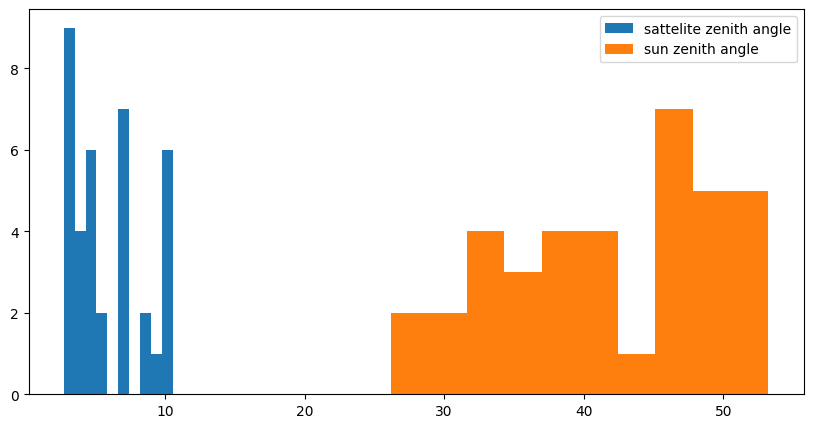

In [144]:
plt.hist(sattelite_zenith_np)
plt.hist(sun_zenith_np)
plt.legend(['sattelite zenith angle','sun zenith angle'])
plt.show()

Text(0.5, 1.0, 'Zenith angles over indexes for available real world images')

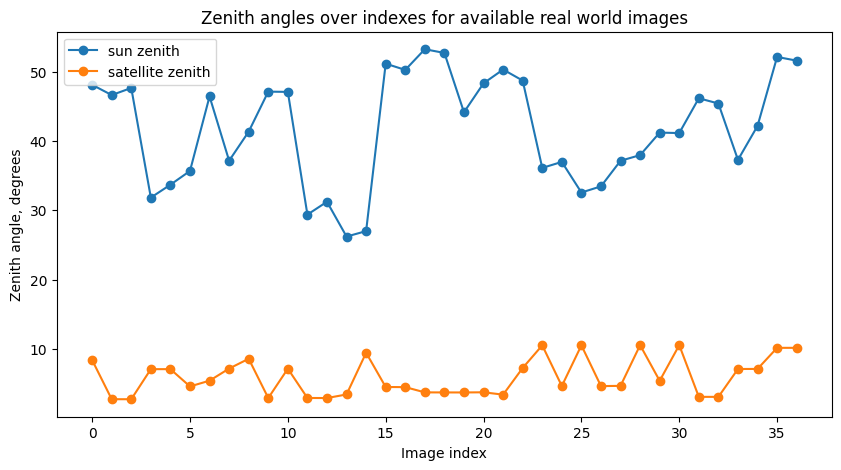

In [145]:
plt.plot(sun_zenith_np,'-o')
plt.plot(sattelite_zenith_np,'-o')
#plt.plot(sun_zenith_np-sattelite_zenith_np)
plt.legend(['sun zenith','satellite zenith'])
plt.xlabel('Image index')
plt.ylabel('Zenith angle, degrees')
plt.title('Zenith angles over indexes for available real world images')

## Temporal Bias in image pairs

In [146]:
which_pair=4 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [147]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 1.0, '2022-06-22T10:05:59.024000000')

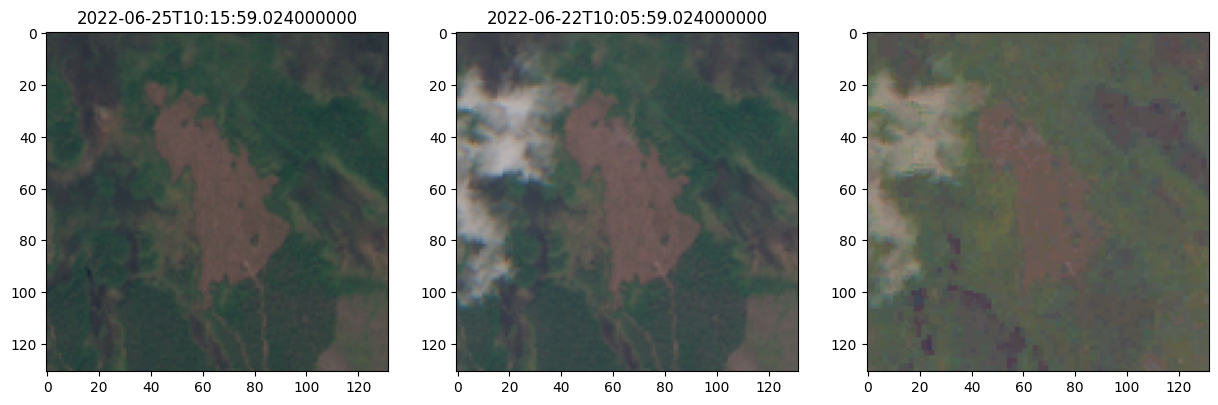

In [148]:
plt.rcParams["figure.figsize"] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(im_clear_show)
axs[1].imshow(im_cloud_show)
axs[2].imshow(im_pred_show)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])

In [149]:
bound_box_forest=np.array([
                    [3,70,90,65,90],
                    [4,100,120,70,100],
                    [8,30,40,5,20],
                    [13,30,40,25,40],
                    [16,25,40,5,20]])#image index, y1,y2,x1,x2

bound_box_cutdown=np.array([[0,35,40,5,12],
                            [2,20,25,23,30],
                            [4,60,80,60,80]])#image index, y1,y2,x1,x2

nmses_forested=np.zeros((len(bound_box_forest),12))
nmses_cutdown=np.zeros((len(bound_box_cutdown),12))

specs_clear_forested=np.zeros((len(bound_box_forest),12))
specs_cloud_forested=np.zeros((len(bound_box_forest),12))

specs_clear_cutdown=np.zeros((len(bound_box_cutdown),12))
specs_cloud_cutdown=np.zeros((len(bound_box_cutdown),12))

for i,box in enumerate(bound_box_forest):
    im_pair=ims_all[box[0]]
    im_clear=im_pair[0]
    im_cloud=im_pair[1]   

    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_cloud_box=im_cloud[box[1]:box[2],box[3]:box[4],:]

    norm_temp=np.linalg.norm((im_clear_box[:,:,0:12])-im_cloud_box[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear_box[:,:,0:12],axis=(0,1))**2

    NMSE_temp=norm_temp/norm_gt
    nmses_forested[i,:]=NMSE_temp

    specs_clear_forested[i,:]=np.mean(im_clear_box,axis=(0,1))[:12]
    specs_cloud_forested[i,:]=np.mean(im_cloud_box,axis=(0,1))[:12] 

for i,box in enumerate(bound_box_cutdown):
    im_pair=ims_all[box[0]]
    im_clear=im_pair[0]
    im_cloud=im_pair[1]   

    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_cloud_box=im_cloud[box[1]:box[2],box[3]:box[4],:]

    norm_temp=np.linalg.norm((im_clear_box[:,:,0:12])-im_cloud_box[:,:,0:12],axis=(0,1))**2
    norm_gt=np.linalg.norm(im_clear_box[:,:,0:12],axis=(0,1))**2

    NMSE_temp=norm_temp/norm_gt
    nmses_cutdown[i,:]=NMSE_temp

    specs_clear_cutdown[i,:]=np.mean(im_clear_box,axis=(0,1))[:12]
    specs_cloud_cutdown[i,:]=np.mean(im_cloud_box,axis=(0,1))[:12] 

bound_box=np.array([
                    [3,70,90,65,90],
                    [4,100,120,70,100],
                    [8,30,40,5,20],
                    [13,30,40,25,40],
                    [16,25,40,5,20],
                    [0,35,40,5,12],
                    [2,20,25,23,30],
                    [4,60,80,60,80]])#image index, y1,y2,x1,x2


specs_clear=np.zeros((len(bound_box),12))
specs_cloud=np.zeros((len(bound_box),12))
for i,box in enumerate(bound_box):
    im_pair=ims_all[box[0]]
    im_clear=im_pair[0]
    im_cloud=im_pair[1]   

    im_clear_box=im_clear[box[1]:box[2],box[3]:box[4],:]
    im_cloud_box=im_cloud[box[1]:box[2],box[3]:box[4],:]

    specs_clear[i,:]=np.mean(im_clear_box,axis=(0,1))[:12]
    specs_cloud[i,:]=np.mean(im_cloud_box,axis=(0,1))[:12] 


In [150]:
np.round(np.mean(nmses_forested,axis=0),4)

array([0.0211, 0.0257, 0.0506, 0.03  , 0.017 , 0.0168, 0.0177, 0.0152,
       0.4157, 0.1312, 0.0268, 0.047 ])

In [151]:
np.round(np.mean(nmses_cutdown,axis=0),4)

array([0.0653, 0.0855, 0.1033, 0.0433, 0.0238, 0.0233, 0.0249, 0.0196,
       0.62  , 2.1674, 0.0079, 0.0189])

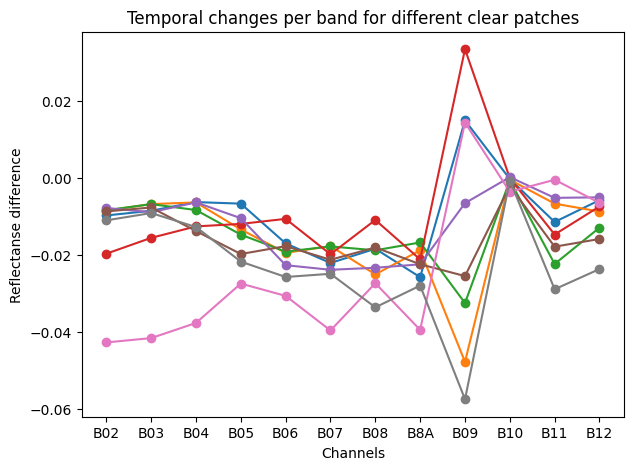

In [152]:
plt.rcParams["figure.figsize"] = [7, 5]
plt.plot(channels,(specs_clear-specs_cloud).T,'-o')
#plt.plot(channels,np.mean(clear_array_c[:,:12],axis=0),'--o')
plt.xlabel("Channels")
plt.ylabel("Reflectanse difference")
plt.title("Temporal changes per band for different clear patches")
plt.show()

In [153]:
which_pair=4 #5, 12
im_cloud=ims_all[which_pair][1]
im_clear=ims_all[which_pair][0]
im_pred=preds_all[which_pair]

In [154]:
im_cloud_show=hf.Sentinel2TrueColor(im_cloud)
im_clear_show=hf.Sentinel2TrueColor(im_clear)
im_pred_show=hf.Sentinel2TrueColor(im_pred)

Text(0.5, 0.98, 'Example bounding box for temporal change analysis')

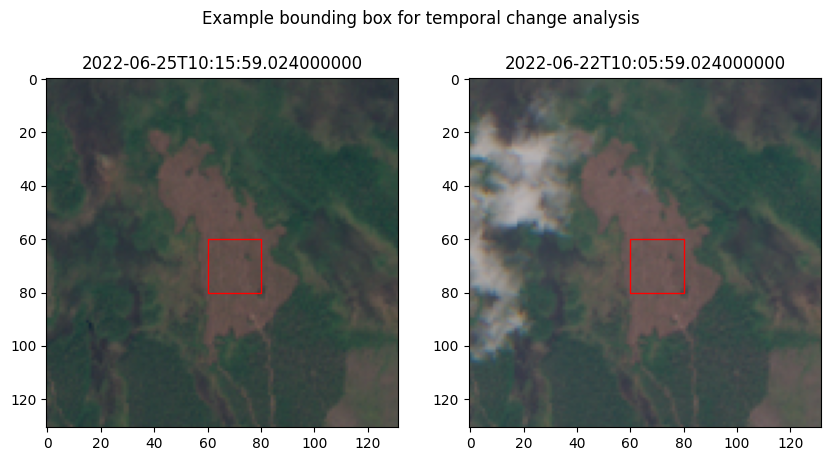

In [155]:
import matplotlib.patches as patches 
box=[60,80,60,80]
rect=patches.Rectangle((box[2],box[0]),box[3]-box[2],box[1]-box[0], edgecolor='r',facecolor='none')
rect_2=patches.Rectangle((box[2],box[0]),box[3]-box[2],box[1]-box[0], edgecolor='r',facecolor='none')

plt.rcParams["figure.figsize"] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(im_clear_show)
axs[0].add_patch(rect)
axs[1].imshow(im_cloud_show)
axs[1].add_patch(rect_2)

axs[0].set_title(temporals_all[which_pair][0])
axs[1].set_title(temporals_all[which_pair][1])
fig.suptitle("Example bounding box for temporal change analysis")